In [265]:
from scipy import stats
import pandas as pd
import numpy as np
import sklearn.preprocessing
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import normalize
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
from functools import reduce
import matplotlib.pyplot as plt
import itertools
import seaborn as sns
%matplotlib inline
import os

In [2]:
# Read the Excel file
df = pd.read_excel('Parts and Dimesions.xlsx')
#print(df.head)

# Do not use the 'Operator' or 'Item_No' column
df = df.drop(columns=['Item_No', 'Operator'])
#print(df.head)

# Remove rows with missing cells
df_nomissing = df.dropna()

In [3]:
###TEST CELL###
'''
#print(type(df_nomissing))
print(df_nomissing)'''

'\n#print(type(df_nomissing))\nprint(df_nomissing)'

In [4]:
directory_startingData = "C:\\Users\\J\\dataframes_startingData"
df_nomissing.to_csv(directory_startingData, index=False)

From this point onward, this dataset will be referred to as our "starting dataset".

In [5]:
def zscoreGlobalOutlier(df, stdev_threshold):
    df_global_outlier_removed = []
    
    for threshold in stdev_threshold:
        # Calculate the z-score for each column
        z_scores = stats.zscore(df)

        # Identify outliers
        outliers_high = z_scores > threshold
        outliers_low = z_scores < threshold*-1

        # Remove outliers from the DataFrame
        df_global_outlier_high_removed = df[~outliers_high.any(axis=1)]
        df_global_outlier_removed.append(df_global_outlier_high_removed[~outliers_low.any(axis=1)])

    return df_global_outlier_removed

In [6]:
def create_df_dict_noOutliers(df_list, threshold_list, df_dict):    
    # Get the starting index position
    start_index = len(df_dict)
    
    # Iterate over each dataframe and threshold in the lists
    for index, (df, threshold) in enumerate(zip(df_list, threshold_list)):
        # Create a dictionary to store dataframe and threshold information
        entry = {'dataframe': df, 'stdev threshold': threshold}

        # Add the entry to the df_dict with the index as the key
        df_dict[index] = entry

    print("Dictionary: dataframe, stdev_thresh")
    return df_dict

In [7]:
df1 = df_nomissing.copy()
stdev_threshold = [2,3]
a = zscoreGlobalOutlier(df1, stdev_threshold)

C:\Users\J\AppData\Local\Temp\ipykernel_33892\1368169788.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_global_outlier_removed.append(df_global_outlier_high_removed[~outliers_low.any(axis=1)])
C:\Users\J\AppData\Local\Temp\ipykernel_33892\1368169788.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_global_outlier_removed.append(df_global_outlier_high_removed[~outliers_low.any(axis=1)])


In [8]:
###TEST CELL###
'''
print(a)'''

'\nprint(a)'

In [9]:
df_dict_full = {}
df_dict_full = create_df_dict_noOutliers(a, stdev_threshold, df_dict_full)

Dictionary: dataframe, stdev_thresh


In [10]:
###TEST CELL###
'''
print(len(df_dict_full))
print(df_dict_full[0])'''

'\nprint(len(df_dict_full))\nprint(df_dict_full[0])'

In [11]:
def extract_dataframes(df_dict):
    dataframes = []
    for entry in df_dict.values():
        dataframes.append(entry['dataframe'])
    return dataframes

In [12]:
df_for_R_full = extract_dataframes(df_dict_full)

In [13]:
###TEST CELL###
'''
print(type(df_for_R_full))
print(len(df_for_R_full))
print(df_for_R_full)'''

'\nprint(type(df_for_R_full))\nprint(len(df_for_R_full))\nprint(df_for_R_full)'

In [14]:
def save_outputs(directory, df_list, filename):
    # Create directory if it doesn't exist
    os.makedirs(directory, exist_ok=True)

    # Iterate over the list of dataframes
    for i, df in enumerate(df_list):
        # Create the full file path
        file_path = os.path.join(directory, f"{filename}_{i}.csv")

        # Save the dataframe as a CSV file
        df.to_csv(file_path, index=False)

In [15]:
directory_full = "C:\\Users\\J\\dataframes_full"
filename = "df_full"
save_outputs(directory_full, df_for_R_full, filename)

At this point, we have 2 full datasets. They exist in a dictionary for easy reference to remind ourselves of what preprocessing has occurred. The step not mention, but performed, was removing NaN. These two datasets have also been saved as .csv files to my (your) local machine. 

In [16]:
def randomly_remove_indices(df_list, percentage_list):
    df_merged_list = []
    df_mergedGT_list = []

    for df in df_list:
        for percentage in percentage_list:
            indices_to_remove = {}
            groundTruth = {}
            new_df = {}
            num_indices = int(len(df) * percentage / 100)

            for column in df.columns:
                indices_to_remove[column] = np.random.choice(df[column].index, size=num_indices, replace=False)
                groundTruth[column] = df[column].loc[indices_to_remove[column]].copy()
                new_df[column] = df[column].copy()
                new_df[column].loc[indices_to_remove[column]] = np.nan

            # Merge the new DataFrames
            df_merged = pd.concat(new_df.values(), axis=1)
            df_mergedGT = pd.concat(groundTruth.values(), axis=1)
            df_mergedGT = df_mergedGT.sort_index()

            # Append the merged DataFrames to the respective lists
            df_merged_list.append(df_merged)
            df_mergedGT_list.append(df_mergedGT)

    return df_merged_list, df_mergedGT_list

In [17]:
percent = [5, 15, 35]
aa = randomly_remove_indices(a, percent)

In [18]:
###TEST CELL###
'''
#print(len(aa))
#print(len(aa[0]))
print(aa[1])'''

'\n#print(len(aa))\n#print(len(aa[0]))\nprint(aa[1])'

In [19]:
def create_dict_for_pre_imputation(df_list, df_missing_dict, threshold_list, percentage_list):
    dataset_index = 0

    # the point of this is to make sure as the dictionary fills, it is correctly tracking 
    # the correct pre-porcessing procedure for each
    for v_index, v_value in enumerate(threshold_list):
        for vv_value in percentage_list:
            entry = {'dataframe': df_list[v_index], 'stdev threshold': v_value, 'missing_percent' : vv_value}
            df_missing_dict[dataset_index] = entry
            dataset_index += 1

    print("Dictionary: dataframe, stdev_thresh, missing_percent")
    return df_missing_dict

In [22]:
stdev_threshold = [2,3]
percent = [5, 15, 35]
preimputation_dict = {}
preimputation_dict = create_dict_for_pre_imputation(aa[0], preimputation_dict, stdev_threshold, percent)

Dictionary: dataframe, stdev_thresh, missing_percent


In [23]:
###TEST CELL###
'''
print(type(q))
print(len(q))
print(q[1]['dataframe'])
print(type(qq))
print(len(qq))'''

"\nprint(type(q))\nprint(len(q))\nprint(q[1]['dataframe'])\nprint(type(qq))\nprint(len(qq))"

In [25]:
df_for_R_missing = extract_dataframes(preimputation_dict)
directory_missing = "C:\\Users\\J\\dataframes_missing"
filename1 = "df_missing"
save_outputs(directory_missing, df_for_R_missing, filename1)

#df_for_R_GT = extract_dataframes(qq)
#directory_GT = "C:\\Users\\J\\dataframes_GT"
#filename2 = "df_GT"
#save_outputs(directory_GT, df_for_R_GT, filename2)

Starting from out "starting dataset". We removed outliers by 2 criteria, resulting in 2 unique datasets. Each dataset then had a random amount of data removed. 

To *attempt* to avoid undue bias, the percent missing was applied to each column. There is a non-zero chance empty rows may have been generated.

3 amounts of missingness were performed on each of the 2 datasets, resulting in 6 unique datasets that contain missing data AND 6 unique datasets that contain the values that were removed. The index values from the "starting dataset" have been maintained in all 12 datasets.

In [26]:
def miceMethod(df_list, max_iter_list):
    df_MICE_imputed_list = []
    df_imputed_values_list = []
    
    for df in df_list:
        for max_iterA in max_iter_list:
            # Create an instance of the MICE imputer
            mice_imputer = IterativeImputer(max_iter=max_iterA)

            # Impute missing values using the MICE algorithm
            df_imputed = mice_imputer.fit_transform(df)

            # Convert the imputed array back to a DataFrame
            df_MICE_imputed = pd.DataFrame(df_imputed, columns=df.columns, index=df.index)

            # Create a DataFrame with just the imputed values
            df_imputed_values = df_MICE_imputed[df.isna()]

            # Append the imputed DataFrames to the respective lists
            df_MICE_imputed_list.append(df_MICE_imputed)
            df_imputed_values_list.append(df_imputed_values)

    return df_MICE_imputed_list, df_imputed_values_list

In [27]:
###TEST CELL###
'''
#aa[0] is missing datasets
print(type(aa[0]))
print(len(aa[0]))'''

'\n#aa[0] is missing datasets\nprint(type(aa[0]))\nprint(len(aa[0]))'

In [28]:
max_iter_list = [3, 5, 10]
w = miceMethod(aa[0], max_iter_list)

C:\Users\J\anaconda3\envs\r_environment_in_jupyternotbook\lib\site-packages\sklearn\impute\_iterative.py:713: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\J\anaconda3\envs\r_environment_in_jupyternotbook\lib\site-packages\sklearn\impute\_iterative.py:713: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\J\anaconda3\envs\r_environment_in_jupyternotbook\lib\site-packages\sklearn\impute\_iterative.py:713: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [29]:
###TEST CELL###
'''
#print(w)
print(type(w))
print(len(w))
print(type(w[0]))
print(len(w[0]))
print(type(w[1]))
print(len(w[1]))
print(type(w[0][0]))
print(len(w[0][0]))'''

'\n#print(w)\nprint(type(w))\nprint(len(w))\nprint(type(w[0]))\nprint(len(w[0]))\nprint(type(w[1]))\nprint(len(w[1]))\nprint(type(w[0][0]))\nprint(len(w[0][0]))'

In [30]:
def create_dict_for_PYMICE_imputation(df_list, df_PYMICE_dict, threshold_list, percentage_list, max_iter_list):
    dataset_index = 0

    # build and layer so that the correct preprocessing is matintained with each dataset
    for v_index, v_value in enumerate(threshold_list):
        for vv_value in percentage_list:
            for vvv_value in max_iter_list:
                entry = {'dataframe': df_list[v_index], 'stdev_thresh': v_value,
                         'missing_percent' : vv_value, 'iterations' : vvv_value}
                df_PYMICE_dict[dataset_index] = entry
                dataset_index += 1

    print("Dictionary: dataframe, stdev_thresh, missing_percent, iterations")
    return df_PYMICE_dict 

In [31]:
def print_dict_without_dataframe(df_PYMICE_dict, index):
    entry = df_PYMICE_dict[index]
    keys_to_exclude = ['dataframe']  # Keys to exclude from printing

    print(f"Index: {index}")
    for key, value in entry.items():
        if key not in keys_to_exclude:
            print(f"{key}: {value}")

In [32]:
z = {}
zz = {}
full_imputed_dict = create_dict_for_PYMICE_imputation(w[0], z, stdev_threshold, percent, max_iter_list)
just_imputed_dict = create_dict_for_PYMICE_imputation(w[1], zz, stdev_threshold, percent, max_iter_list)

Dictionary: dataframe, stdev_thresh, missing_percent, iterations
Dictionary: dataframe, stdev_thresh, missing_percent, iterations


In [33]:
###TEST CELL###
'''
print(type(z))
print(len(z))
print(z[1])
print(z[1]['dataframe'])
print(print_dict_without_dataframe(z))
#print(type(zz))
#print(len(zz))'''

"\nprint(type(z))\nprint(len(z))\nprint(z[1])\nprint(z[1]['dataframe'])\nprint(print_dict_without_dataframe(z))\n#print(type(zz))\n#print(len(zz))"

In [34]:
df_for_R_imputedFull = extract_dataframes(z)
directory_imputedFull = "C:\\Users\\J\\dataframes_imputedFull"
filename3 = "df_imputedFull"
save_outputs(directory_imputedFull, df_for_R_imputedFull, filename3)

df_for_R_justImputed = extract_dataframes(zz)
directory_justImputed = "C:\\Users\\J\\dataframes_justImputed"
filename4 = "df_justImputed"
save_outputs(directory_justImputed, df_for_R_justImputed, filename4)

From our "starting dataset", 2 different outlier thresholds, 3 degrees of missingness, and on each of those datasets 3 MICE imputations were performed, with increasing numbers of imputations. This has generated 18 unique datasets. In one file, the 18 unique datasets are maintained as the full datasets, on the other, the datasets are just the imputed values, with NaN everywhere else.

Very important to note: the order of these are imperative. As 3 MICE datasets were generated from 1 missing dataset, there is 1 ground truth for 3 MICE datasets. 

This means that if MICE[0:3] are built from missing[0], they utilize groundTruth[0]. MICE[3:6] from missing[1] utilize groundTruth[1], etc.

In [35]:
def NaNfilter(df_list):
    filtered_dfs = []  # List to store the filtered DataFrames
    
    for df in df_list:
        filtered_cols = []  # List to store filtered columns
        
        for column in df.columns:
            filtered_col = df[column].dropna()  # Drop NaN values
            filtered_cols.append(filtered_col)  # Store filtered column in the list
        
        # Combine filtered columns into a new DataFrame
        filtered_imputes = pd.concat(filtered_cols, axis=1)
        
        # Add the DataFrame to the list
        filtered_dfs.append(filtered_imputes)
    
    return filtered_dfs

In [36]:
#w[1] is just the imputed values
#aa[1] is the ground truth values
imputed_values = w[1]
GT = aa[1]

In [37]:
###TEST CELL###
'''
#print(imputed_values)
print(len(imputed_values)) # 3 imputes for each GT/ this makes sense
#print(GT)
print(len(GT))
print(len(GT[0]))
#print(GT[0])'''

'\n#print(imputed_values)\nprint(len(imputed_values)) # 3 imputes for each GT/ this makes sense\n#print(GT)\nprint(len(GT))\nprint(len(GT[0]))\n#print(GT[0])'

In [38]:
imputed = NaNfilter(imputed_values)

In [39]:
###TEST CELL###
'''
print(type(G_T))
print(type(imputed))
print(len(G_T))
print(len(imputed))
print(type(G_T[0]))
print(len(G_T[0]))
print(type(imputed[0]))
print(len(imputed[0]))

#print(G_T[0])
#print(G_T)
print("xxxxxxxxxxxxxxxxxxxxxx")'''

'\nprint(type(G_T))\nprint(type(imputed))\nprint(len(G_T))\nprint(len(imputed))\nprint(type(G_T[0]))\nprint(len(G_T[0]))\nprint(type(imputed[0]))\nprint(len(imputed[0]))\n\n#print(G_T[0])\n#print(G_T)\nprint("xxxxxxxxxxxxxxxxxxxxxx")'

In [72]:
def accuracy(groundTruth, predictedData):
    num_ground_truth = len(groundTruth)
    num_predicted_data = len(predictedData)
    num_imputations_per_set = num_predicted_data // num_ground_truth
    
    accuracy_results_df = []
    accuracy_results_col = []
    
    for i in range(num_ground_truth):
        start_index = i * num_imputations_per_set
        end_index = start_index + num_imputations_per_set

        # flatten ground truth for ground truth df
        gt_df = groundTruth[i]
        
        gt_df_Series = pd.Series()
        for col in gt_df.columns:
            gt_df_Series = pd.concat([gt_df_Series, gt_df[col].dropna()])
        gt_df_Series = gt_df_Series.reset_index(drop=True)

        # flatten ground truth for each column 
        gt_col_Series = []
        for col in gt_df.columns:
            series = gt_df[col]
            series = series.dropna()
            series = series.reset_index(drop=True)
            gt_col_Series.append(pd.Series(series))
        
        for j in range(start_index, end_index):
            pd_df = predictedData[j] # Get the predicted data for this imputation
        
            pd_df_Series = pd.Series()
            for col in pd_df.columns:
                pd_df_Series = pd.concat([pd_df_Series, pd_df[col].dropna()])
            pd_df_Series = pd_df_Series.reset_index(drop=True)

            # flatten ground truth for each column 
            pd_col_Series = []
            for col in pd_df.columns:
                series = pd_df[col]
                series = series.dropna()
                series = series.reset_index(drop=True)
                pd_col_Series.append(pd.Series(series))

            # Calculate metrics at the df level
            accuracyPercent_df = np.round((gt_df_Series - pd_df_Series) / gt_df_Series * 100)
            mean_accuracy_df = np.round(np.mean(accuracyPercent_df), 2)
            stdev_accuracy_df = np.round(np.std(accuracyPercent_df), 2)
            var_df = np.round(predictedData[j].var(), 2)
            mse_df = np.round(mean_squared_error(gt_df_Series, pd_df_Series, squared=False), 2)
            
            accuracy_results_df.append((accuracyPercent_df, mean_accuracy_df, 
                                     stdev_accuracy_df, var_df, mse_df))

            # Calculate metrics at the col level
            for A, B in zip(gt_col_Series, pd_col_Series):
                    accuracyPercent_col = np.round((A - B) / A * 100)
                    mean_accuracy_col = np.round(np.mean(accuracyPercent_col), 2)
                    stdev_accuracy_col = np.round(np.std(accuracyPercent_col), 2)
                    var_col = np.round(B.var(), 2)
                    mse_col = np.round(mean_squared_error(A, B, squared=False), 2)
                    
                    accuracy_results_col.append((accuracyPercent_col, mean_accuracy_col,
                                            stdev_accuracy_col, var_col, mse_col))
    
    print("accuracy results cell by cell for df \n", "accuracy % across df:", mean_accuracy_df, "\n",
          "stdev across df:", stdev_accuracy_df, "\n", "variance across df:", var_df, "\n",
          "mse across df:", mse_df, "\n", "accuracy results cell by cell for columns \n", "accuracy % across column:",
          mean_accuracy_col, "\n", "stdev across column:", stdev_accuracy_col, "\n", "variance across col:",
          var_col, "\n", "mse across column:", mse_col)
    
    return accuracy_results_df, accuracy_results_col

In [73]:
x = accuracy(GT, imputed)

accuracy results cell by cell for df 
 accuracy % across df: -0.2 
 stdev across df: 4.3 
 variance across df: Length    0.50
Width     0.16
Height    0.01
dtype: float64 
 mse across df: 2.5 
 accuracy results cell by cell for columns 
 accuracy % across column: -0.25 
 stdev across column: 4.98 
 variance across col: 0.01 
 mse across column: 1.0


C:\Users\J\AppData\Local\Temp\ipykernel_33892\4028562387.py:18: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  gt_df_Series = pd.concat([gt_df_Series, gt_df[col].dropna()])
C:\Users\J\AppData\Local\Temp\ipykernel_33892\4028562387.py:34: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  pd_df_Series = pd.concat([pd_df_Series, pd_df[col].dropna()])
C:\Users\J\AppData\Local\Temp\ipykernel_33892\4028562387.py:34: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when d

In [45]:
###TEST CELL###
'''
print(type(x))
print(len(x))
print(type(x[0]))
print(len(x[0]))
print(x[1][3])'''    

'\nprint(type(x))\nprint(len(x))\nprint(type(x[0]))\nprint(len(x[0]))\nprint(x[1][3])'

In [46]:
def max_df_accuracy_list(df_list):
    # Create a list of tuples containing the 'mean_accuracy' values and their corresponding indices
    accuracy_indices = [(i, abs(results[1])) for i, results in enumerate(df_list)]
    
    # Sort the list of tuples by 'mean_accuracy' values in descending order
    sorted_accuracy_indices = sorted(accuracy_indices, key=lambda x: x[1], reverse=False)
    
    return sorted_accuracy_indices

In [47]:
df_x = x[0]
s = max_df_accuracy_list(df_x)

In [48]:
###TEST CELL###
'''
print(s)'''  

'\nprint(s)'

In [49]:
print_dict_without_dataframe(z, 12)

Index: 12
stdev_thresh: 3
missing_percent: 15
iterations: 3


In [50]:
def df_stats(df, storage):
    for col in df.columns:
        summary = df[col].describe()
        count = summary.loc['count']
        mean = summary.loc['mean']
        std_dev = summary.loc['std']
        var = df[col].var()
        storage.append((count, np.round(mean, 2), np.round(std_dev, 2), np.round(var, 2)))
    print("Count, mean, std_dev, variance")

In [189]:
descript_stat_start = []
start = df_nomissing.copy()
df_stats(start, descript_stat_start)
print(len(descript_stat_start))
print(descript_stat_start)

Count, mean, std_dev, variance
3
[(455.0, 99.68, 4.17, 17.38), (455.0, 49.94, 2.15, 4.62), (455.0, 20.31, 1.06, 1.12)]


In [53]:
def df_list_stats(df_list, storage):
    for df in df_list:
        df_col = []
        for col in df.columns:
            summary = df[col].describe()
            count = summary.loc['count']
            mean = summary.loc['mean']
            std_dev = summary.loc['std']
            var = df[col].var()
            df_col.append((count, np.round(mean, 2), np.round(std_dev, 2), np.round(var, 2)))
        storage.append(df_col)
    print("Count, mean, std_dev, variance")

In [190]:
sa = a.copy()
descript_stat_noOuts = []
df_list_stats(sa, descript_stat_noOuts)
print(len(descript_stat_noOuts))
print(descript_stat_noOuts[0])
print(descript_stat_noOuts[1])

Count, mean, std_dev, variance
2
[(408.0, 99.15, 3.13, 9.81), (408.0, 49.87, 1.8, 3.24), (408.0, 20.25, 1.0, 1.0)]
[(446.0, 99.46, 3.83, 14.7), (446.0, 49.91, 2.05, 4.2), (446.0, 20.28, 1.04, 1.08)]


In [191]:
saa = aa[0].copy()
descript_stat_missing = []
df_list_stats(saa, descript_stat_missing)
print(len(descript_stat_missing))
print(descript_stat_missing[0:4])

Count, mean, std_dev, variance
6
[[(388.0, 99.11, 3.14, 9.86), (388.0, 49.88, 1.78, 3.18), (388.0, 20.27, 1.0, 1.0)], [(347.0, 99.21, 3.06, 9.39), (347.0, 49.89, 1.79, 3.22), (347.0, 20.23, 1.0, 1.0)], [(266.0, 99.11, 3.13, 9.81), (266.0, 49.89, 1.84, 3.4), (266.0, 20.23, 1.0, 1.0)], [(424.0, 99.48, 3.89, 15.11), (424.0, 49.9, 2.06, 4.26), (424.0, 20.26, 1.05, 1.1)]]


In [188]:
ssaa = w[0].copy()
descript_stat_imputed = []
df_list_stats(ssaa, descript_stat_imputed)
print(len(descript_stat_imputed))
print(descript_stat_imputed[0:5])

Count, mean, std_dev, variance
18
[[(408.0, 99.11, 3.06, 9.38), (408.0, 49.88, 1.74, 3.03), (408.0, 20.27, 0.97, 0.95)], [(408.0, 99.11, 3.06, 9.38), (408.0, 49.88, 1.74, 3.03), (408.0, 20.27, 0.97, 0.95)], [(408.0, 99.11, 3.06, 9.38), (408.0, 49.88, 1.74, 3.03), (408.0, 20.27, 0.97, 0.95)], [(408.0, 99.21, 2.82, 7.98), (408.0, 49.89, 1.65, 2.74), (408.0, 20.23, 0.92, 0.85)], [(408.0, 99.21, 2.82, 7.98), (408.0, 49.89, 1.65, 2.74), (408.0, 20.23, 0.92, 0.85)]]


In [94]:
zx = x[0].copy()
zzxx = x[1].copy()
print(len(zx))
print(len(zzxx))
print(zzxx[0][1:])

18
54
(0.7, 2.63, 0.0, 2.96)


In [95]:
print(zzxx[1:])

[(0     3.0
1    -8.0
2    -8.0
3     5.0
4     0.0
5     5.0
6    -4.0
7    -4.0
8    -3.0
9    -5.0
10   -4.0
11    2.0
12    3.0
13   -3.0
14    5.0
15   -3.0
16    3.0
17    4.0
18   -1.0
19   -2.0
Name: Width, dtype: float64, -0.75, 4.15, 0.0, 2.07), (0     -3.0
1     -0.0
2     -4.0
3      2.0
4     -2.0
5      5.0
6      1.0
7     -7.0
8     -1.0
9     -9.0
10    -3.0
11    -8.0
12    -3.0
13    -1.0
14    -6.0
15     6.0
16    -9.0
17   -10.0
18     2.0
19    -0.0
Name: Height, dtype: float64, -2.5, 4.5, 0.0, 0.99), (0     5.0
1    -1.0
2     2.0
3     2.0
4    -2.0
5     1.0
6     4.0
7     1.0
8    -3.0
9     4.0
10    4.0
11    3.0
12   -1.0
13    3.0
14   -2.0
15    0.0
16    2.0
17   -4.0
18   -2.0
19   -2.0
Name: Length, dtype: float64, 0.7, 2.63, 0.0, 2.96), (0     3.0
1    -8.0
2    -8.0
3     5.0
4     0.0
5     5.0
6    -4.0
7    -4.0
8    -3.0
9    -5.0
10   -4.0
11    2.0
12    3.0
13   -3.0
14    5.0
15   -3.0
16    3.0
17    4.0
18   -1.0
19   -2.0
Name: Width, dt

In [194]:
def acc_stat_extract(df, storage):
    df_L = []
    df_W = []
    df_H = []
    for i in range(len(df)):

        if i % 3 == 0:
            df_L.append(df[i][1:])
        elif i % 3 == 1:
            df_W.append(df[i][1:])
        elif i % 3 == 2:
            df_H.append(df[i][1:])

    for L, W, H in zip(df_L, df_W, df_H):
        storage.append((L, W, H))
    print("mean, std_dev, variance, mse")

In [215]:
mice_accuracy_descript_stats = []
#zzxx = x[1].copy()
acc_stat_extract(zzxx, mice_accuracy_descript_stats)
print(len(mice_accuracy_descript_stats))
print(mice_accuracy_descript_stats[0:18][0])
v = len(mice_accuracy_descript_stats[0:18][0])
print(v)
for element in mice_accuracy_descript_stats[:][0][0]:
    print(element)
print(mice_accuracy_descript_stats)

mean, std_dev, variance, mse
18
((0.7, 2.63, 0.0, 2.96), (-0.75, 4.15, 0.0, 2.07), (-2.5, 4.5, 0.0, 0.99))
3
0.7
2.63
0.0
2.96
[((0.7, 2.63, 0.0, 2.96), (-0.75, 4.15, 0.0, 2.07), (-2.5, 4.5, 0.0, 0.99)), ((0.7, 2.63, 0.0, 2.96), (-0.75, 4.15, 0.0, 2.07), (-2.5, 4.5, 0.0, 0.99)), ((0.7, 2.63, 0.0, 2.96), (-0.75, 4.15, 0.0, 2.07), (-2.5, 4.5, 0.0, 0.99)), ((-0.48, 3.43, 0.0, 3.5), (-0.38, 3.72, 0.0, 1.83), (0.49, 4.9, 0.0, 1.0)), ((-0.48, 3.43, 0.0, 3.5), (-0.38, 3.72, 0.0, 1.83), (0.49, 4.9, 0.0, 1.0)), ((-0.48, 3.43, 0.0, 3.5), (-0.38, 3.72, 0.0, 1.83), (0.49, 4.9, 0.0, 1.0)), ((0.0, 3.12, 0.14, 3.13), (-0.3, 3.49, 0.07, 1.73), (0.1, 4.97, 0.0, 0.99)), ((0.02, 3.13, 0.24, 3.13), (-0.3, 3.48, 0.1, 1.74), (0.13, 4.96, 0.0, 0.99)), ((0.02, 3.13, 0.24, 3.13), (-0.3, 3.48, 0.1, 1.74), (0.13, 4.96, 0.0, 0.99)), ((-0.45, 2.64, 0.51, 2.61), (0.18, 3.74, 0.24, 1.87), (1.91, 4.01, 0.01, 0.93)), ((-0.45, 2.64, 0.51, 2.61), (0.18, 3.74, 0.24, 1.87), (1.91, 4.01, 0.01, 0.93)), ((-0.45, 2.64, 0.51, 

In [262]:
mice_mean_L = []
mice_mean_W = []
mice_mean_H = []
mice_std_L = []
mice_std_W = []
mice_std_H = []
mice_var_L = []
mice_var_W = []
mice_var_H = []
mice_mse_L = []
mice_mse_W = []
mice_mse_H = []

In [263]:
for tup in cc:
    for j in range(len(tup[0])):       
        if j == 0:
            mice_mean_L.append(tup[0][j])
        elif j == 1:
            mice_std_L.append(tup[0][j])
        elif j == 2:
            mice_var_L.append(tup[0][j])
        elif j == 3:
            mice_mse_L.append(tup[0][j])

for tup in cc:
    for j in range(len(tup[1])):       
        if j == 0:
            mice_mean_W.append(tup[1][j])
        elif j == 1:
            mice_std_W.append(tup[1][j])
        elif j == 2:
            mice_var_W.append(tup[1][j])
        elif j == 3:
            mice_mse_W.append(tup[1][j])

for tup in cc:
    for j in range(len(tup[2])):       
        if j == 0:
            mice_mean_H.append(tup[2][j])
        elif j == 1:
            mice_std_H.append(tup[2][j])
        elif j == 2:
            mice_var_H.append(tup[2][j])
        elif j == 3:
            mice_mse_H.append(tup[2][j])

18

In [ ]:
# not sure about the couple of cells above this

At this point I've run some stuff in R to generate some data about the starting datasets pre imputation and maybe analyze some of the python imputed? But I have at least 4 datasets imputed from R that are more Bayesian applications of MICE along with a RF. 

In [342]:
folder_path = "C:\\Users\\J\\from_R\\pmm"
csv_pmm = [file for file in os.listdir(folder_path) if file.endswith(".csv")]

In [343]:
df_pmm = []
for file in csv_pmm:
    file_path = os.path.join(folder_path, file)
    df = pd.read_csv(file_path)
    df_pmm.append(df)

In [344]:
print(len(df_pmm))
print(df_pmm[0]) #looks like indices not preserved. Shouldn't be a problem since data is fully imputed

18
     Length  Width  Height
0    102.67  49.53   19.69
1    102.50  49.13   21.38
2     95.37  52.25   21.51
3     94.77  49.24   18.60
4    104.26  47.90   19.46
..      ...    ...     ...
403   98.34  49.03   19.30
404  101.24  52.50   20.96
405   98.37  52.12   19.68
406   94.16  48.39   21.60
407  102.35  51.24   21.47

[408 rows x 3 columns]


In [273]:
folder_path = "C:\\Users\\J\\from_R\\cart"
csv_cart = [file for file in os.listdir(folder_path) if file.endswith(".csv")]
df_cart = []
for file in csv_cart:
    file_path = os.path.join(folder_path, file)
    df = pd.read_csv(file_path)
    df_cart.append(df)

In [274]:
print(len(df_cart))
print(df_cart[0])

18
     Length  Width  Height
0    102.67  49.53   19.69
1    102.50  51.42   18.66
2     95.37  52.25   21.51
3     94.77  49.24   18.60
4    104.26  47.90   19.46
..      ...    ...     ...
403   98.34  49.03   19.30
404  101.24  50.00   20.96
405   98.37  52.12   19.68
406   94.16  48.39   21.60
407  102.35  51.24   21.47

[408 rows x 3 columns]


In [275]:
folder_path = "C:\\Users\\J\\from_R\\BLR"
csv_BLR = [file for file in os.listdir(folder_path) if file.endswith(".csv")]
df_BLR = []
for file in csv_BLR:
    file_path = os.path.join(folder_path, file)
    df = pd.read_csv(file_path)
    df_BLR.append(df)

In [276]:
print(len(df_BLR))
print(df_BLR[0])

18
     Length      Width     Height
0    102.67  49.530000  19.690000
1    102.50  48.035976  18.607753
2     95.37  52.250000  21.510000
3     94.77  49.240000  18.600000
4    104.26  47.900000  19.460000
..      ...        ...        ...
403   98.34  49.030000  19.300000
404  101.24  48.735525  20.960000
405   98.37  52.120000  19.680000
406   94.16  48.390000  21.600000
407  102.35  51.240000  21.470000

[408 rows x 3 columns]


In [277]:
folder_path = "C:\\Users\\J\\from_R\\RF"
csv_RF = [file for file in os.listdir(folder_path) if file.endswith(".csv")]
df_RF = []
for file in csv_RF:
    file_path = os.path.join(folder_path, file)
    df = pd.read_csv(file_path)
    df_RF.append(df)

In [278]:
print(len(df_RF))
print(df_RF[0])

18
     Length  Width  Height
0    102.67  49.53   19.69
1    102.50  50.61   19.63
2     95.37  52.25   21.51
3     94.77  49.24   18.60
4    104.26  47.90   19.46
..      ...    ...     ...
403   98.34  49.03   19.30
404  101.24  52.46   20.96
405   98.37  52.12   19.68
406   94.16  48.39   21.60
407  102.35  51.24   21.47

[408 rows x 3 columns]


In [345]:
#print(GT)
def extract_imputed_values(original_dfs, imputed_dfs):
    imputed_values_list = []
    num_original_dfs = len(original_dfs)
    num_imputed_dfs = len(imputed_dfs)
    num_imputations_per_set = num_imputed_dfs // num_original_dfs
    
    for i in range(num_original_dfs):
        start_index = i * num_imputations_per_set
        end_index = start_index + num_imputations_per_set

        original_df = original_dfs[i].reset_index(drop=True)  # Reset the index
        
        for j in range(start_index, end_index):
            imputed_df = imputed_dfs[j]
            # Create a boolean mask where True indicates the position of NaN values in the original DataFrame
            mask = original_df.isna()

            # Use the mask to extract the imputed values from the imputed DataFrame
            imputed_values = imputed_df[mask]

            imputed_values_list.append(imputed_values)

    return imputed_values_list

In [346]:
#going to reupload the exact dataset used in R
folder_path = "C:\\Users\\J\\dataframes_missing\\"
csv_gtm = [file for file in os.listdir(folder_path) if file.endswith(".csv")]
df_gtm = []
for file in csv_gtm:
    file_path = os.path.join(folder_path, file)
    df = pd.read_csv(file_path)
    df_gtm.append(df)

In [348]:
#going to reupload the exact dataset used in R got the missing values
folder_path = "C:\\Users\\J\\dataframes_GT\\"
csv_gt = [file for file in os.listdir(folder_path) if file.endswith(".csv")]
df_gt = []
for file in csv_gt:
    file_path = os.path.join(folder_path, file)
    df = pd.read_csv(file_path)
    df_gt.append(df)

In [349]:
#print(GT)
def extract_imputed_values1(original_gts, imputed_dfs):
    imputed_values_list = []
    num_original_gts = len(original_gts)
    num_imputed_dfs = len(imputed_dfs)
    num_imputations_per_set = num_imputed_dfs // num_original_gts
    
    for i in range(num_original_gts):
        start_index = i * num_imputations_per_set
        end_index = start_index + num_imputations_per_set

        original_df = original_gts[i].reset_index(drop=True)  # Reset the index
        
        for j in range(start_index, end_index):
            imputed_df = imputed_dfs[j]
            # Create a boolean mask where True indicates the position of NaN values in the original DataFrame
            mask = original_df.isna()

            # Use the mask to extract the imputed values from the imputed DataFrame
            imputed_values = imputed_df[mask]

            imputed_values_list.append(imputed_values)

    return imputed_values_list

In [352]:
df_pmm_imputes = extract_imputed_values1(df_gt, df_pmm)
print(len(df_pmm_imputes))
print(len(df_pmm_imputes[0]))

18
408


In [354]:
df_pmm_imputedOnly = NaNfilter(df_pmm_imputes)
print(len(df_pmm_imputedOnly))
print(len(df_pmm_imputedOnly[0]))

18
55


In [355]:
for i in range(len(df_pmm_imputedOnly)):
    print(len(df_pmm_imputedOnly[i]))
print("XXX")
for i in range(len(df_gt)):
    print(len(df_gt[i]))

55
55
55
55
55
55
55
55
55
154
154
154
154
154
154
154
154
154
XXX
55
55
55
156
156
156


In [356]:
df_blr_imputes = extract_imputed_values1(df_gt, df_BLR)
print(len(df_blr_imputes))
print(len(df_blr_imputes[0]))

18
408


In [357]:
df_blr_imputedOnly = NaNfilter(df_blr_imputes)
print(len(df_blr_imputedOnly))
print(len(df_blr_imputedOnly[0]))
print("XXX")
for i in range(len(df_blr_imputedOnly)):
    print(len(df_blr_imputedOnly[i]))

18
55
XXX
55
55
55
55
55
55
55
55
55
154
154
154
154
154
154
154
154
154


In [358]:
df_cart_imputes = extract_imputed_values1(df_gt, df_cart)
print(len(df_cart_imputes))
print(len(df_cart_imputes[0]))
print("XXX")
df_cart_imputedOnly = NaNfilter(df_cart_imputes)
print(len(df_cart_imputedOnly))
print(len(df_cart_imputedOnly[0]))
print("XXX")
for i in range(len(df_cart_imputedOnly)):
    print(len(df_cart_imputedOnly[i]))

18
408
XXX
18
55
XXX
55
55
55
55
55
55
55
55
55
154
154
154
154
154
154
154
154
154


In [359]:
df_RF_imputes = extract_imputed_values1(df_gt, df_RF)
print(len(df_RF_imputes))
print(len(df_RF_imputes[0]))
print("XXX")
df_RF_imputedOnly = NaNfilter(df_RF_imputes)
print(len(df_RF_imputedOnly))
print(len(df_RF_imputedOnly[0]))
print("XXX")
for i in range(len(df_RF_imputedOnly)):
    print(len(df_RF_imputedOnly[i]))

18
408
XXX
18
55
XXX
55
55
55
55
55
55
55
55
55
154
154
154
154
154
154
154
154
154


In [366]:
df_pmm_imputes = df_pmm_imputes[0:6]
df_pmm_imputes = df_pmm_imputes[0:6]
df_blr_imputes = df_blr_imputes[0:6]
df_RF_imputes = df_RF_imputes[0:6]
df_gt = df_gt[0:3]

In [365]:
def accuracy1(groundTruth, predictedData):
    num_ground_truth = len(groundTruth)
    num_predicted_data = len(predictedData)
    num_imputations_per_set = num_predicted_data // num_ground_truth
    
    accuracy_results_df = []
    accuracy_results_col = []
    
    for i in range(num_ground_truth):
        start_index = i * num_imputations_per_set
        end_index = start_index + num_imputations_per_set

        # flatten ground truth for ground truth df
        gt_df = groundTruth[i]
        
        gt_df_Series = pd.Series()
        for col in gt_df.columns:
            gt_df_Series = pd.concat([gt_df_Series, gt_df[col].dropna()])
        gt_df_Series = gt_df_Series.reset_index(drop=True)

        # flatten ground truth for each column 
        gt_col_Series = []
        for col in gt_df.columns:
            series = gt_df[col]
            series = series.dropna()
            series = series.reset_index(drop=True)
            gt_col_Series.append(pd.Series(series))
        
        for j in range(start_index, end_index):
            pd_df = predictedData[j] # Get the predicted data for this imputation
        
            pd_df_Series = pd.Series()
            for col in pd_df.columns:
                pd_df_Series = pd.concat([pd_df_Series, pd_df[col].dropna()])
            pd_df_Series = pd_df_Series.reset_index(drop=True)

            # flatten ground truth for each column 
            pd_col_Series = []
            for col in pd_df.columns:
                series = pd_df[col]
                series = series.dropna()
                series = series.reset_index(drop=True)
                pd_col_Series.append(pd.Series(series))

            # Calculate metrics at the df level
            accuracyPercent_df = np.round((gt_df_Series - pd_df_Series) / gt_df_Series * 100)
            mean_accuracy_df = np.round(np.mean(accuracyPercent_df), 2)
            stdev_accuracy_df = np.round(np.std(accuracyPercent_df), 2)
            var_df = np.round(predictedData[j].var(), 2)
            #mse_df = np.round(mean_squared_error(gt_df_Series, pd_df_Series, squared=False), 2)
            
            accuracy_results_df.append((accuracyPercent_df, mean_accuracy_df, 
                                     stdev_accuracy_df, var_df))#, mse_df

            # Calculate metrics at the col level
            for A, B in zip(gt_col_Series, pd_col_Series):
                    accuracyPercent_col = np.round((A - B) / A * 100)
                    mean_accuracy_col = np.round(np.mean(accuracyPercent_col), 2)
                    stdev_accuracy_col = np.round(np.std(accuracyPercent_col), 2)
                    var_col = np.round(B.var(), 2)
                    #mse_col = np.round(mean_squared_error(A, B, squared=False), 2)
                    
                    accuracy_results_col.append((accuracyPercent_col, mean_accuracy_col,
                                            stdev_accuracy_col, var_col))#, mse_col
    
    print("accuracy results cell by cell for df \n", "accuracy % across df:", mean_accuracy_df, "\n",
          "stdev across df:", stdev_accuracy_df, "\n", "variance across df:", var_df, "\n",
           "accuracy results cell by cell for columns \n", "accuracy % across column:", #"mse across df:", mse_df, "\n",
          mean_accuracy_col, "\n", "stdev across column:", stdev_accuracy_col, "\n", "variance across col:",
          var_col, "\n")#, "mse across column:", mse_col
    
    return accuracy_results_df, accuracy_results_col

In [369]:
acc_pmm = accuracy1(df_gt, df_pmm_imputes)
acc_cart = accuracy1(df_gt, df_cart_imputes)
acc_blr = accuracy1(df_gt, df_blr_imputes)
acc_RF = accuracy1(df_gt, df_RF_imputes)

accuracy results cell by cell for df 
 accuracy % across df: -73.65 
 stdev across df: 65.15 
 variance across df: Length    12.20
Width      3.94
Height     0.93
dtype: float64 
 accuracy results cell by cell for columns 
 accuracy % across column: 2.6 
 stdev across column: 5.36 
 variance across col: 0.93 

accuracy results cell by cell for df 
 accuracy % across df: -167.53 
 stdev across df: 170.01 
 variance across df: Length    13.84
Width      3.50
Height     0.98
dtype: float64 
 accuracy results cell by cell for columns 
 accuracy % across column: 1.15 
 stdev across column: 5.98 
 variance across col: 0.98 

accuracy results cell by cell for df 
 accuracy % across df: -74.47 
 stdev across df: 66.02 
 variance across df: Length    12.32
Width      3.93
Height     0.89
dtype: float64 
 accuracy results cell by cell for columns 
 accuracy % across column: 1.7 
 stdev across column: 5.23 
 variance across col: 0.89 

accuracy results cell by cell for df 
 accuracy % across df: 

C:\Users\J\AppData\Local\Temp\ipykernel_33892\1213763440.py:18: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  gt_df_Series = pd.concat([gt_df_Series, gt_df[col].dropna()])
C:\Users\J\AppData\Local\Temp\ipykernel_33892\1213763440.py:34: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  pd_df_Series = pd.concat([pd_df_Series, pd_df[col].dropna()])
C:\Users\J\AppData\Local\Temp\ipykernel_33892\1213763440.py:34: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when d

In [375]:
p = max_df_accuracy_list(acc_pmm[1])
c = max_df_accuracy_list(acc_cart[1])
b = max_df_accuracy_list(acc_blr[1])
r = max_df_accuracy_list(acc_RF[1])

In [376]:
p

[(4, 0.2),
 (15, 0.4),
 (10, 0.5),
 (0, 0.6),
 (3, 0.6),
 (9, 0.6),
 (12, 0.6),
 (6, 0.65),
 (11, 0.7),
 (1, 0.75),
 (13, 0.85),
 (7, 0.9),
 (16, 1.1),
 (5, 1.35),
 (14, 1.35),
 (2, 1.4),
 (8, 2.35),
 (17, 2.6)]

In [382]:
print(len(p))

18


In [377]:
c

[(28, 0.05),
 (22, 0.1),
 (24, 0.15),
 (3, 0.2),
 (15, 0.2),
 (10, 0.3),
 (1, 0.4),
 (9, 0.4),
 (16, 0.4),
 (21, 0.4),
 (18, 0.45),
 (6, 0.5),
 (0, 0.55),
 (12, 0.55),
 (13, 0.6),
 (25, 0.6),
 (49, 0.6),
 (52, 0.65),
 (4, 0.75),
 (34, 0.75),
 (31, 0.8),
 (35, 0.85),
 (40, 0.85),
 (7, 0.9),
 (43, 0.9),
 (46, 0.9),
 (19, 0.95),
 (50, 0.95),
 (44, 1.0),
 (37, 1.15),
 (47, 1.15),
 (53, 1.15),
 (11, 1.25),
 (23, 1.25),
 (41, 1.25),
 (27, 1.3),
 (20, 1.35),
 (33, 1.35),
 (45, 1.35),
 (51, 1.35),
 (2, 1.4),
 (30, 1.4),
 (36, 1.5),
 (39, 1.5),
 (42, 1.5),
 (29, 1.55),
 (38, 1.55),
 (48, 1.65),
 (14, 1.75),
 (32, 1.8),
 (26, 2.05),
 (5, 2.2),
 (17, 2.45),
 (8, 2.65)]

In [378]:
b

[(3, 0.15),
 (10, 0.15),
 (13, 0.2),
 (16, 0.3),
 (15, 0.35),
 (6, 0.5),
 (9, 0.5),
 (4, 0.55),
 (0, 0.6),
 (1, 0.6),
 (5, 0.65),
 (12, 0.65),
 (7, 0.8),
 (14, 1.2),
 (2, 1.4),
 (8, 1.55),
 (17, 1.7),
 (11, 2.0)]

In [379]:
r

[(12, 0.05),
 (13, 0.25),
 (6, 0.3),
 (3, 0.4),
 (9, 0.4),
 (15, 0.45),
 (0, 0.5),
 (1, 0.6),
 (7, 0.9),
 (10, 0.9),
 (4, 0.95),
 (14, 1.05),
 (16, 1.05),
 (2, 1.4),
 (11, 1.45),
 (5, 1.5),
 (17, 1.7),
 (8, 2.15)]

In [338]:
print(len(GT_for_test[0]))
print(len(pmm[0]))

print(len(pmm_imputed_wNaN))
print(len(pmm_imputed_wNaN[0]))
#print(pmm_imputed_wNaN[0])

55
408
18
408


In [ ]:
blr_imputed_wNaN = extract_imputed_values(GT_for_test, df_BLR)

In [320]:
pmm_acc = accuracy(GT, imputed_pmm)

C:\Users\J\AppData\Local\Temp\ipykernel_33892\4028562387.py:18: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  gt_df_Series = pd.concat([gt_df_Series, gt_df[col].dropna()])
C:\Users\J\AppData\Local\Temp\ipykernel_33892\4028562387.py:34: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  pd_df_Series = pd.concat([pd_df_Series, pd_df[col].dropna()])
C:\Users\J\AppData\Local\Temp\ipykernel_33892\4028562387.py:34: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when d

ValueError: Found input variables with inconsistent numbers of samples: [66, 62]

In [98]:
import seaborn as sns
import matplotlib.pyplot as plt

18
3
4
<class 'tuple'>
<class 'tuple'>
<class 'numpy.float64'>
(0.7, 2.63, 0.0, 2.96)
(-0.75, 4.15, 0.0, 2.07)


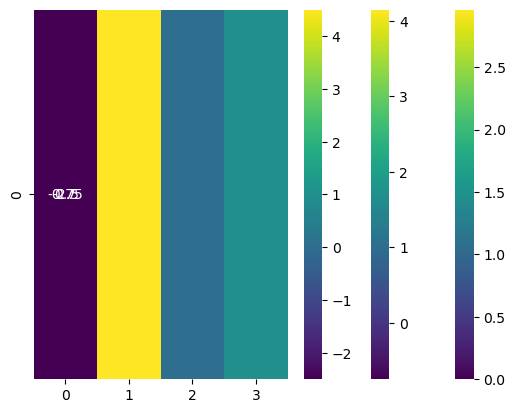

In [164]:
print(len(mice_accuracy_descript_stats))
print(len(mice_accuracy_descript_stats[0]))
print(len(mice_accuracy_descript_stats[0][0]))
print(type(mice_accuracy_descript_stats[0]))
print(type(mice_accuracy_descript_stats[0][0]))
print(type(mice_accuracy_descript_stats[0][0][0]))
print(mice_accuracy_descript_stats[0][0])
print(mice_accuracy_descript_stats[0][1])

cc = np.array(mice_accuracy_descript_stats[0])

for tup in cc:
    # Convert tuple to 2D array
    data_array = np.array(tup).reshape(1, -1)

    # Create heatmap
    sns.heatmap(data_array, annot=True, cmap='viridis')


#print(cc.shape)
#sns.heatmap(cc, annot=True, cmap='viridis')


At this point in the code, I moved over to Google Colab. I wanted to do the whole thing here, but I was having a difficult time with R and some of these libraries.

In [ ]:
'''
I run R and python through anaconda. This is run locally in my r_jupyternotebook environment. 
The following libraries were downloaded via anaconda:
conda install conda-forge::r-data.table
conda install conda-forge::r-ggplot2
conda install conda-forge::r-mice
conda install conda-forge::r-missforest
conda install conda-forge::r-corrplot
conda install conda-forge::r-brms
conda install conda-forge::r-withr
conda install conda-forge::r-rstan
'''

In [ ]:
install.packages("rstan", repos = c("https://mc-stan.org/r-packages/", getOption("repos")))

In [ ]:
library(data.table)
library(mice)
library(missForest)
library(corrplot)
library(ggplot2)
library(brms)

In [ ]:
#library(parallel) #???

In [ ]:
# Create an empty list to store the data frames
df_list <- list()

# List all CSV files in the directory
csv_files <- list.files(path = "C:\\Users\\J\\dataframes", pattern = "\\.csv$", full.names = TRUE)

# Loop through each CSV file
for (file in csv_files) {
  # Read the CSV file into a data.table
  df <- fread(file)
  
  # Add the data.table to the list
  df_list[[file]] <- df
}

In [ ]:
#print(length(df_list))
#print(df_list[[4]])  

In [ ]:
#confirmed works. retunrs full dataframes
miceAuto_pmm <- function(df_list, num_interations) {
    complete_mice_imputed_data_final <- list()

    # Iterate through dfs in df_list
    for (i in 1:length(df_list)) {        
        # Iterate through each num_interations
        for (j in num_iterations) {
            # Process each data table and save the output to the new list
            mice_imputed_data <- mice(df_list[[i]], method = "pmm", m = j)
            complete_mice_imputed_data <- complete(mice_imputed_data,j)
            complete_mice_imputed_data_final[[paste0("df", i, "_imp", j)]] <- as.data.frame(complete_mice_imputed_data)
            print(complete_mice_imputed_data_final)
            }
        }
    return (complete_mice_imputed_data_final)
}

In [ ]:
#works as intended
clean_onlyImputed <- function(df_list_fully_imputed, df_list_missing) {
    num_list_missing <- length(df_list_missing)
    num_predicted_data <- length(df_list_fully_imputed)
    num_imputations_per_set <- num_predicted_data / num_list_missing
    
    clean_onlyImputed <- list()
    clean_only <- list()

    # Iterate through dfs in df_list
    for (i in 1:num_list_missing) {
        start_index <- (i-1) * num_imputations_per_set + 1
        end_index <- start_index + num_imputations_per_set - 1
        
        missing <- df_list_missing[[i]]

        # Iterate through each num_interations
        for (j in start_index:end_index) {
            full <- df_list_fully_imputed[[j]]
            only_mice_imputed_data <- full
            only_mice_imputed_data[!is.na(missing)] <- NA
            only_mice_imputed_data[[1]] <- full[[1]]
            clean_onlyImputed[[paste0("df", i, "_imp", j)]] <- only_mice_imputed_data
        }
        }
    #clean_onlyImputed_final <- as.data.frame(clean_onlyImputed)
    return (clean_onlyImputed)
}

In [ ]:
#confirmed works. retunrs full dataframes
miceAuto_cart <- function(df_list, num_interations) {
    complete_mice_imputed_data_final <- list()

    # Iterate through dfs in df_list
    for (i in 1:length(df_list)) {        
        # Iterate through each num_interations
        for (j in num_iterations) {
            # Process each data table and save the output to the new list
            mice_imputed_data <- mice(df_list[[i]], method = "cart", m = j)
            complete_mice_imputed_data <- complete(mice_imputed_data,j)
            complete_mice_imputed_data_final[[paste0("df", i, "_imp", j)]] <- as.data.frame(complete_mice_imputed_data)
            print(complete_mice_imputed_data_final)
            }
        }
    return (complete_mice_imputed_data_final)
}

In [ ]:
#confirmed works. retunrs full dataframes
miceAuto_BLR <- function(df_list, num_interations) {
    complete_mice_imputed_data_final <- list()

    # Iterate through dfs in df_list
    for (i in 1:length(df_list)) {        
        # Iterate through each num_interations
        for (j in num_iterations) {
            # Process each data table and save the output to the new list
            mice_imputed_data <- mice(df_list[[i]], method = "norm", m = j)
            complete_mice_imputed_data <- complete(mice_imputed_data,j)
            complete_mice_imputed_data_final[[paste0("df", i, "_imp", j)]] <- as.data.frame(complete_mice_imputed_data)
            print(complete_mice_imputed_data_final)
            }
        }
    return (complete_mice_imputed_data_final)
}

In [ ]:
#confirmed works. retunrs full dataframes
miceAuto_RF <- function(df_list, num_interations) {
    complete_mice_imputed_data_final <- list()

    # Iterate through dfs in df_list
    for (i in 1:length(df_list)) {        
        # Iterate through each num_interations
        for (j in num_iterations) {
            # Process each data table and save the output to the new list
            mice_imputed_data <- mice(df_list[[i]], method = "rf", m = j)
            complete_mice_imputed_data <- complete(mice_imputed_data,j)
            complete_mice_imputed_data_final[[paste0("df", i, "_imp", j)]] <- as.data.frame(complete_mice_imputed_data)
            print(complete_mice_imputed_data_final)
            }
        }
    return (complete_mice_imputed_data_final)
}

In [ ]:
#confirmed works. retunrs full dataframes
miceAuto_log <- function(df_list, num_interations) {
    complete_mice_imputed_data_final <- list()

    # Iterate through dfs in df_list
    for (i in 1:length(df_list)) {        
        # Iterate through each num_interations
        for (j in num_iterations) {
            # Process each data table and save the output to the new list
            mice_imputed_data <- mice(df_list[[i]], method = "logreg", m = j)
            complete_mice_imputed_data <- complete(mice_imputed_data,j)
            complete_mice_imputed_data_final[[paste0("df", i, "_imp", j)]] <- as.data.frame(complete_mice_imputed_data)
            print(complete_mice_imputed_data_final)
            }
        }
    return (complete_mice_imputed_data_final)
}

In [ ]:
#confirmed works. retunrs full dataframes
miceAuto_logregboot <- function(df_list, num_interations) {
    complete_mice_imputed_data_final <- list()

    # Iterate through dfs in df_list
    for (i in 1:length(df_list)) {        
        # Iterate through each num_interations
        for (j in num_iterations) {
            # Process each data table and save the output to the new list
            mice_imputed_data <- mice(df_list[[i]], method = "logreg.boot", m = j)
            complete_mice_imputed_data <- complete(mice_imputed_data,j)
            complete_mice_imputed_data_final[[paste0("df", i, "_imp", j)]] <- as.data.frame(complete_mice_imputed_data)
            print(complete_mice_imputed_data_final)
            }
        }
    return (complete_mice_imputed_data_final)
}

In [ ]:
#confirmed works. retunrs full dataframes
missForest_Impute <- function(df_list, num_interations) {
    complete_missForest_imputed_data_final <- list()

    # Iterate through dfs in df_list
    for (i in 1:length(df_list)) {        
        # Iterate through each num_interations
        for (j in num_iterations) {
            # Process each data table and save the output to the new list
            missForest_imputed_data <- missForest(df_list[[i]], maxiter = j)
            #complete_missForest_imputed_data <- complete(missForest_imputed_data,j)
            complete_missForest_imputed_data_final[[paste0("df", i, "_imp", j)]] <- as.data.frame(missForest_imputed_data$ximp)
            print(complete_missForest_imputed_data_final)
            }
        }
    return (complete_missForest_imputed_data_final)
}

In [ ]:
test1 <- list()
test2 <- list()
test3 <- list()
test4 <- list()
test5 <- list()
test6 <- list()
test7 <- list()
test1 <- df_list
test2 <- df_list
test3 <- df_list
test4 <- df_list
test5 <- df_list
test6 <- df_list
test7 <- df_list
num_iterations <- list(1, 3)

In [ ]:
q <- miceAuto_pmm(test1, num_iterations)
print(typeof(q))
print(length(q))
print("XXXXXXXX")
print(typeof(q[[1]]))
print(length(q[[1]]))
print(q)
print(q[[1]])

In [ ]:
#qq <- miceAuto_cart(test2, num_iterations)
print(typeof(qq))
print(length(qq))
print("XXXXXXXX")
print(typeof(qq[[1]]))
print(length(qq[[1]]))
print(qq)
print(qq[[1]])

In [ ]:
#qqq <- miceAuto_BLR(test3, num_iterations)
print(typeof(qqq))
print(length(qqq))
print("XXXXXXXX")
print(typeof(qqq[[1]]))
print(length(qqq[[1]]))
print(qqq)
print(qqq[[1]])

In [ ]:
#qqqq <- miceAuto_RF(test4, num_iterations)
print(typeof(qqqq))
print(length(qqqq))
print("XXXXXXXX")
print(typeof(qqqq[[1]]))
print(length(qqqq[[1]]))
print(qqqq)
print(qqqq[[1]])

In [ ]:
'''qqqqq <- miceAuto_log(test5, num_iterations)
print(typeof(qqqqq))
print(length(qqqqq))
print("XXXXXXXX")
print(typeof(qqqqq[[1]]))
print(length(qqqqq[[1]]))
print(qqqqq)
print(qqqqq[[1]])'''

In [ ]:
'''qqqqqq <- miceAuto_logregboot(test6, num_iterations)
print(typeof(qqqqqq))
print(length(qqqqqq))
print("XXXXXXXX")
print(typeof(qqqqqq[[1]]))
print(length(qqqqqq[[1]]))
print(qqqqqq)
print(qqqqqq[[1]])'''

In [ ]:
#qqqqqq <- missForest_Impute(test6, num_iterations)
print(typeof(qqqqqq))
print(length(qqqqqq))
print("XXXXXXXX")
print(typeof(qqqqqq[[1]]))
print(length(qqqqqq[[1]]))
print(qqqqqq)
print(qqqqqq[[1]])

In [ ]:
print(test7[[1]])

In [ ]:
'''library(devtools)
Sys.setenv(PATH = paste("C:\\rtools44\\mingw_64\\bin", Sys.getenv("PATH"), sep=";"))
Sys.setenv(BINPREF = "C:\\rtools44\\mingw_64\\bin\\")'''

In [ ]:
'''library(devtools)
Sys.setenv(PATH = paste("C:\\Users\\J\\ANACON~1\\envs\\R_ENVI~1\\Rtools\\mingw_64\\bin", Sys.getenv("PATH"), sep=";"))
Sys.setenv(BINPREF = "C:\\Users\\J\\ANACON~1\\envs\\R_ENVI~1\\Rtools\\mingw_64\\bin\\")'''

In [ ]:
'''library(devtools)
Sys.setenv(PATH = paste("C:\\Users\\J\\ANACON~1\\envs\\R_ENVI~1\\Rtools\\mingw_64\\bin", Sys.getenv("PATH"), sep=";"))
Sys.setenv(BINPREF = "C:\\Users\\J\\ANACON~1\\envs\\R_ENVI~1\\Rtools\\mingw_64\\bin\\")'''

In [ ]:
'''Sys.which("g++")'''

In [ ]:
'''system("g++ -v")'''

In [ ]:
'''Sys.which("Rtools")'''

In [ ]:
'''install.packages("ggplot2")'''

In [ ]:
'''install.packages(c("farver", "cli", "lifecycle", "rlang", "scales", "vctrs"))'''

In [ ]:
'''Sys.which("gcc")'''

In [ ]:
'''library(ggplot2)'''

In [ ]:
update.packages(ask = FALSE)

In [ ]:
fit1 <- brm(Length ~ Width + Height,
            data = q[[1]], family = gaussian())

In [ ]:
test <- list()
test <- df_list
num_iterations <- list(1, 3)
#print(num_iterations[[1]])
#print(typeof(test))
#print(length(test))
qqq <- miceAuto_pmm(test, num_iterations)
print(length(qqq))
#testing <- test[[1]]
#testinging <- testing[[1]]
#print(length(testinging))

In [ ]:
#confirmed works. retunrs full dataframes
miceAuto_logregboot <- function(df_list, num_interations) {
    complete_mice_imputed_data_final <- list()

    # Iterate through dfs in df_list
    for (i in 1:length(df_list)) {        
        # Iterate through each num_interations
        for (j in num_iterations) {
            # Process each data table and save the output to the new list
            mice_imputed_data <- mice(df_list[[i]], method = "logreg.boot", m = j)
            complete_mice_imputed_data <- complete(mice_imputed_data,j)
            complete_mice_imputed_data_final[[paste0("df", i, "_imp", j)]] <- as.data.frame(complete_mice_imputed_data)
            print(complete_mice_imputed_data_final)
            }
        }
    return (complete_mice_imputed_data_final)
}

In [ ]:
a <- clean_onlyImputed(qqq, test)
print(typeof(a))
print(length(a))
print(length(a[[1]]))
a[[1]]

In [ ]:
#works as intended
create_dict_for_PYMICE_imputation <- function(df_list, df_PYMICE_dict, threshold_list, percentage_list, 
                                              max_iter_list, imputation) {
    dataset_index <- 1
  
    for (v_value in threshold_list) {
        for (vv_value in percentage_list) {
            for (vvv_value in max_iter_list) {
                entry <- list("dataframe" = df_list[[dataset_index]], "stdev_thresh" = v_value, 
                "missing_percent" = vv_value, "iterations" = vvv_value, "MICE_imputation" = imputation)
                df_PYMICE_dict[[dataset_index]] <- entry
                dataset_index <- dataset_index + 1
                }
            }
        }
  
    print("Dictionary: dataframe, stdev_thresh, missing_percent, iterations, MICE_imputation")
    return(df_PYMICE_dict)
}

In [ ]:
threshold_list <- list(2, 3)
percentage_list <- list(5, 15, 35)
max_iter_list <- list(1, 3)
df_PYMICE_dict <- list()
aa <- a
imputation <- "pmm"
qw <- create_dict_for_PYMICE_imputation(aa, df_PYMICE_dict, threshold_list, percentage_list, max_iter_list, imputation)

In [ ]:
print(typeof(qw))
print(length(qw))
print(length(qw[[1]]))
qw[[1]][["missing_percent"]]
for (i in qw) {
    print (i[["missing_percent"]])
}

In [ ]:
df <- as.data.frame(qw)
directory <- "C:\\Users\\J\\Outputs_From_R"
R_dict <- "df_dictionary_R.csv"
file_path <- file.path(directory, file_name)
write.csv(df, file = file_path, row.names = FALSE)

In [ ]:
df_list <- as.data.frame(a)
directory <- "C:\\Users\\J\\Outputs_From_R"
R_dict <- "imputed_values_R.csv"
file_path <- file.path(directory, file_name)
write.csv(df, file = file_path, row.names = FALSE)

In [ ]:
print(packageVersion("missForest"))

In [ ]:
#for reference from python
def create_dict_for_PYMICE_imputation(df_list, df_PYMICE_dict, threshold_list, percentage_list, max_iter_list):
    dataset_index = 0

    for v_index, v_value in enumerate(threshold_list):
        for vv_value in percentage_list:
            for vvv_value in max_iter_list:
                entry = {'dataframe': df_list[v_index], 'stdev_thresh': v_value,
                         'missing_percent' : vv_value, 'iterations' : vvv_value}
                df_PYMICE_dict[dataset_index] = entry
                dataset_index += 1

    print("Dictionary: dataframe, stdev_thresh, missing_percent, iterations")
    return df_PYMICE_dict 

In [ ]:
def miceMethod(df_list, max_iter_list):
    df_MICE_imputed_list = []
    df_imputed_values_list = []
    
    for df in df_list:
        for max_iterA in max_iter_list:
            # Create an instance of the MICE imputer
            mice_imputer = IterativeImputer(max_iter=max_iterA)

            # Impute missing values using the MICE algorithm
            df_imputed = mice_imputer.fit_transform(df)

            # Convert the imputed array back to a DataFrame
            df_MICE_imputed = pd.DataFrame(df_imputed, columns=df.columns, index=df.index)

            # Create a DataFrame with just the imputed values
            df_imputed_values = df_MICE_imputed[df.isna()]

            # Append the imputed DataFrames to the respective lists
            df_MICE_imputed_list.append(df_MICE_imputed)
            df_imputed_values_list.append(df_imputed_values)

    return df_MICE_imputed_list, df_imputed_values_list

In [ ]:
#confirmed works

pureImputedValues_fromList <- function(df_OGdata_with_missing, df_full_with_imputations) {
    imputed_values_df_final <- list()

    # Iterate through each data table in the list. Ensure that the correct datatables are being used! Equivalent index values!
    for (i in 1:length(df_list)) {
        # Compare data from each df
        imputed_values <- is.na(df_OGdata_with_missing[[i]]) & !is.na(df_full_with_imputations[[i]])

        # Extract the V1 column from the original dataframe
        V1_column <- df_OGdata_with_missing[[i]]$V1

        # Create a copy of the imputed dataframe
        imputed_values_df <- df_full_with_imputations[[i]]

        # Replace non-imputed values with NA in the copied dataframe
        imputed_values_df[!imputed_values] <- NA

        # Add the V1 column to the copied dataframe
        imputed_values_df$V1 <- V1_column

        # Convert the imputed values to a dataframe if needed
        imputed_values_df_final[[i]] <- as.data.frame(imputed_values_df)

        }
    print(imputed_values_df_final)
}

In [ ]:
plot_histogram <- function(df) {
    # Create a ggplot object with geom_histogram for each column
    L <- ggplot(df, aes(x = Length)) + geom_histogram(color = "#000000", fill = "#0099F8") +
    ggtitle("Length Distribution") + theme_classic() + theme(plot.title = element_text(size = 18))
 
    # Add geom_histogram for the Width column
    W <- ggplot(df, aes(x = Width)) + geom_histogram(color = "#000000", fill = "#0099F8") +
    ggtitle("Width Distribution") + theme_classic() + theme(plot.title = element_text(size = 18))
  
    # Add geom_histogram for the Height column
    H <- ggplot(df, aes(x = Height)) + geom_histogram(color = "#000000", fill = "#0099F8") +
    ggtitle("Height Distribution") + theme_classic() + theme(plot.title = element_text(size = 18))
  
    return(list(L, W, H))
    }

In [ ]:
new_list <- list()
list_of_datatables <- df_list

# Iterate through each data table in the list
for (i in 1:length(list_of_datatables)) {
    # Process each data table and save the output to the new list
    processed_data <- plot_histogram(list_of_datatables[[i]])
    new_list[[i]] <- processed_data
}

new_list

In [ ]:
'''df <- df_list[[4]]
for (col in names(df)) {
    print(ggplot(df, aes(x = .data[[col]])) +
    geom_histogram(color = "#000000", fill = "#0099F8") +
    ggtitle("Variable distribution") +
    theme_classic() +
    theme(plot.title = element_text(size = 18))
    )}'''

In [ ]:
df1 <- df_list[[4]][["Height"]]
df2 <- df_list[[4]]
#df1
#df2
#df3 <- df2[, c("V1", "Length"), with = FALSE]
#df3
#df3 <- as.data.frame(df3)
df2 <- as.data.frame(df2)
#md.pattern(df2)
df2

#tempData <- mice(df2,m=5,maxit=50,meth='pmm',seed=500)
#summary(tempData)

In [ ]:
#confirmed this works
miceAuto <- function(df_list) {
    complete_mice_imputed_data_final <- list()
    
    # Iterate through each data table in the list
    for (i in 1:length(df_list)) {
        # Process each data table and save the output to the new list
        mice_imputed_data <- mice(df_list[[i]], method = "pmm", m = 5)
        complete_mice_imputed_data <- complete(mice_imputed_data,1)
        complete_mice_imputed_data_final[[i]] <- as.data.frame(complete_mice_imputed_data)
        }
    print(complete_mice_imputed_data_final)
}

In [ ]:
miceAuto <- function(df_list) {
    # Iterate through each data table in the list
    for (i in 1:length(df_list)) {
        # Process each data table and save the output to the new list
        mice_imputed_data <- mice(list_of_datatables[[i]], method = "pmm", m = 5)
        complete_mice_imputed_data <- complete(mice_imputed_data,1)
        }
}

In [ ]:
test <- list()
test <- df_list
num_iterations <- list(3, 5, 10)
print(num_iterations[[1]])
qqq <- miceAuto1(test)
typeof(qqq)
length(qqq)

In [ ]:
print(qqq[[1]])

In [ ]:
test <- list()
test <- df_list
qq <- miceAuto(test)
qq[[1]]

In [ ]:
df2 <- as.data.frame(df2)
# Loop through each CSV file
for (file in csv_files) {
  # Read the CSV file into a data.table
  df <- fread(file)
  
  # Add the data.table to the list
  df_list[[file]] <- df
}

In [ ]:
imputed <- mice(df2, method = "pmm", m = 5)
#summary(imputed)
completedData <- complete(imputed,1)
completedData1 <- complete(imputed,5)
summary(completedData)
summary(completedData1)

In [ ]:
pureImputedValues_fromList <- function(df_OGdata_with_missing, df_full_with_imputations) {
    imputed_values_df_final <- list()

    # Iterate through each data table in the list. Ensure that the correct datatables are being used! Equivalent index values!
    for (i in 1:length(df_list)) {
        # Compare data from each df
        imputed_values <- is.na(df_OGdata_with_missing[[i]]) & !is.na(df_full_with_imputations[[i]])

        # Extract the V1 column from the original dataframe
        V1_column <- df_OGdata_with_missing[[i]]$V1

        # Create a copy of the imputed dataframe
        imputed_values_df <- df_full_with_imputations[[i]]

        # Replace non-imputed values with NA in the copied dataframe
        imputed_values_df[!imputed_values] <- NA

        # Add the V1 column to the copied dataframe
        imputed_values_df$V1 <- V1_column

        # Convert the imputed values to a dataframe if needed
        imputed_values_df_final <- as.data.frame(imputed_values_df)

        }
    print(imputed_values_df_final)
}

pureImputedValues <- function(df_OGdata_with_missing, df_full_with_imputations) {
    # Compare data from each df
    imputed_values <- is.na(df_OGdata_with_missing) & !is.na(df_full_with_imputations)

    # Extract the V1 column from the original dataframe
    V1_column <- df_OGdata_with_missing$V1

    # Create a copy of the imputed dataframe
    imputed_values_df <- df_full_with_imputations

    # Replace non-imputed values with NA in the copied dataframe
    imputed_values_df[!imputed_values] <- NA

    # Add the V1 column to the copied dataframe
    imputed_values_df$V1 <- V1_column

    # Convert the imputed values to a dataframe if needed
    imputed_values_df <- as.data.frame(imputed_values_df)

    print(imputed_values_df)
    }

In [ ]:
aa <- pureImputedValues_fromList(test, qq)

In [ ]:
#this works and has been tested
pureImputedValues <- function(df_OGdata_with_missing, df_full_with_imputations) {
    # Compare data from each df
    imputed_values <- is.na(df_OGdata_with_missing) & !is.na(df_full_with_imputations)

    # Extract the V1 column from the original dataframe
    V1_column <- df_OGdata_with_missing$V1

    # Create a copy of the imputed dataframe
    imputed_values_df <- df_full_with_imputations

    # Replace non-imputed values with NA in the copied dataframe
    imputed_values_df[!imputed_values] <- NA

    # Add the V1 column to the copied dataframe
    imputed_values_df$V1 <- V1_column

    # Convert the imputed values to a dataframe if needed
    imputed_values_df <- as.data.frame(imputed_values_df)
    }

In [ ]:
pureImputedValues <- function(df_OGdata_with_missing, df_full_with_imputations) {
    # Compare data from each df
    imputed_values <- is.na(df_OGdata_with_missing) & !is.na(df_full_with_imputations)

    # Extract the V1 column from the original dataframe
    V1_column <- df_OGdata_with_missing$V1

    # Create a copy of the imputed dataframe
    imputed_values_df <- df_full_with_imputations

    # Replace non-imputed values with NA in the copied dataframe
    imputed_values_df[!imputed_values] <- NA

    # Add the V1 column to the copied dataframe
    imputed_values_df$V1 <- V1_column

    # Convert the imputed values to a dataframe if needed
    imputed_values_df <- as.data.frame(imputed_values_df)
    }

In [ ]:
xxx <-pureImputedValues(df2, completedData)
xxx[[1]]

In [ ]:
imputed_values <- is.na(df2) & !is.na(completedData)

# Extract the V1 column from the original dataframe
V1_column <- df2$V1

# Create a copy of the imputed dataframe
imputed_values_df <- completedData

# Replace non-imputed values with NA in the copied dataframe
imputed_values_df[!imputed_values] <- NA

# Add the V1 column to the copied dataframe
imputed_values_df$V1 <- V1_column

# Convert the imputed values to a dataframe if needed
imputed_values_df <- as.data.frame(imputed_values_df)

print(imputed_values_df)

In [ ]:

mice_imputed <- data.frame(
  original = titanic_train$Age,
  imputed_pmm = complete(mice(titanic_numeric, method = "pmm"))$Age,
  imputed_cart = complete(mice(titanic_numeric, method = "cart"))$Age,
  imputed_lasso = complete(mice(titanic_numeric, method = "lasso.norm"))$Age
)
mice_imputed

In [ ]:
perform_imputations <- function(df_list, MICEfunc, num_imputations) {
    # Specify the column names to iterate over
    column_names <- c("Length", "Width", "Height")
  
    # Initialize an empty list to store the imputed data frames
    imputed_list <- list()
  
    # Iterate over each data frame in the list
    for (df in df_list) {
        # Initialize an empty data frame to store the imputed values
        imputed_df <- data.frame(original = numeric(0))
    
        # Iterate over each column name
        for (col_name in column_names) {
            # Perform multiple imputations on the current column
            imputed_col <- complete(mice(df[, ..col_name, drop = FALSE], method = MICEfunc, m = num_imputations))[[col_name]]
      
            # Combine the imputed column with the existing imputed data frame
            imputed_df <- cbind(imputed_df, imputed_col)
            }
    
        # Remove the empty original column and append the imputed data frame to the list
        imputed_df <- imputed_df[, -1]
        imputed_list <- c(imputed_list, list(imputed_df))
        }
  
    return(imputed_list)
    }


In [ ]:
# Usage example
imputed_data <- perform_imputations(df_list, "pmm", 3)


# Usage example
#imputed_data <- perform_imputations(df_list)

In [ ]:
mice_imputed <- data.frame(
  original = df3$Length,
  imputed_pmm = complete(mice(df3, method = "pmm"))$Length,
  imputed_cart = complete(mice(df3, method = "cart"))$Length,
  imputed_lasso = complete(mice(df3, method = "lasso.norm"))$Length
)
mice_imputed

In [ ]:
perform_imputations <- function(df_list, MICEfunc, num_imputations) {
    # Specify the column name to iterate over
    column_name <- "Height"
  
    # Initialize an empty list to store the imputed data frames
    imputed_list <- list()
  
    # Iterate over each data frame in the list
    for (df in df_list) {
        # Perform multiple imputations on the current column
        imputed_col <- complete(mice(df[, column_name, drop = FALSE], method = MICEfunc, m = num_imputations))[[column_name]]
      
        # Append the imputed data frame to the list
        imputed_list <- c(imputed_list, list(imputed_col))
    }
  
    return(imputed_list)
}

In [ ]:
x <- perform_imputations(df, "pmm", 3)

In [ ]:
df <- df_list[[4]]

imputed_df <- lapply(df, function(x) {
    if (is.numeric(x)) {
    replace(x, is.na(x), mean(x, na.rm = TRUE))
  } else {
    x
  }
})
# Convert the list back to a data frame
imputed_df <- as.data.frame(imputed_df)

# Print the imputed data frame
print(imputed_df)

In [ ]:
'''def NaNfilter(df_list):
    filtered_dfs = []  # List to store the filtered DataFrames
    for df in df_list:
        filtered_cols = {}  # Dictionary to store filtered columns for each DataFrame
        print("DataFrame:")
        for column in df.columns:
            dropped_col = df[column].dropna()
            filtered_cols[column] = dropped_col  # Store filtered column in dictionary
            print(column, '\n', dropped_col)
        filtered_df = pd.DataFrame(filtered_cols)  # Convert filtered columns dictionary to DataFrame
        filtered_dfs.append(filtered_df)  # Append filtered DataFrame to the list
    return filtered_dfs'''

In [ ]:
def NaNfilter(df_list):
    filtered_dfs = []  # List to store the filtered DataFrames
    for df in df_list:
        filtered_cols = {}  # Dictionary to store filtered columns for each DataFrame
        for column in df.columns:
            dropped_col = df[column].dropna()
            filtered_cols[column] = dropped_col  # Store filtered column in dictionary
            print(dropped_col.to_string(header=False))  # Print non-null values without header
            #print(column, '\n', dropped_col)
        filtered_df = pd.DataFrame(filtered_cols)  # Convert filtered columns dictionary to DataFrame
        filtered_dfs.append(filtered_df)  # Append filtered DataFrame to the list
    return filtered_dfs

def accuracy(groundTruth, predictedData):
    groundTruth = np.array(groundTruth, dtype=np.float64)
    predictedData = np.array(predictedData, dtype=np.float64)
    delta = groundTruth - predictedData
    accuracyPercent = (delta / groundTruth * 100)
    accuracyPercent = np.round(accuracyPercent, 2)
    min = np.round(np.min(accuracyPercent), 2)
    max = np.round(np.max(accuracyPercent), 2)
    mean = np.round(np.mean(accuracyPercent), 2)
    return print(accuracyPercent, '\n', 'Minimum %:', min, '\n', 'Maximum %:', max, '\n', 'Average Accuracy %:', mean)

def mse(groundTruth, predictedData):
    mse = mean_squared_error(groundTruth, predictedData)
    return print("Mean Squared Error (MSE): ", np.round(mse, 2))

In [ ]:
def NaNfilterPrint(df_list):
    cleaned = []  # List to store cleaned dataframes
    for df in df_list:
        dropped_cols = []  # List to store dropped columns for each dataframe
        for column in df.columns:
            dropped_col = df[column].dropna().tolist()  # Convert dropped column to list
            dropped_cols.append(dropped_col)  # Append dropped column to list
        cleaned.append(dropped_cols)  # Append dropped columns for this dataframe to cleaned list
    return pd.DataFrame(cleaned)

In [ ]:
def NaNfilter(df_list):
    cleaned = []  # List to store cleaned dataframes
    for df in df_list:
        dropped_cols = []  # List to store dropped columns for each dataframe
        for column in df.columns:
            dropped_col = df[column].dropna().tolist()  # Convert dropped column to list
            dropped_cols.append(dropped_col)  # Append dropped column to list
        cleaned.append(dropped_cols)  # Append dropped columns for this dataframe to cleaned list
    return cleaned

def accuracy(groundTruth, predictedData):
    groundTruth = np.array(groundTruth, dtype=np.float64)
    predictedData = np.array(predictedData, dtype=np.float64)
    delta = groundTruth - predictedData
    accuracyPercent = (delta / groundTruth * 100)
    accuracyPercent = np.round(accuracyPercent, 2)
    min = np.round(np.min(accuracyPercent), 2)
    max = np.round(np.max(accuracyPercent), 2)
    mean = np.round(np.mean(accuracyPercent), 2)
    return print(accuracyPercent, '\n', 'Minimum %:', min, '\n', 'Maximum %:', max, '\n', 'Average Accuracy %:', mean)

def mse(groundTruth, predictedData):
    mse = mean_squared_error(groundTruth, predictedData)
    return print("Mean Squared Error (MSE): ", np.round(mse, 2))

In [ ]:
imputed = NaNfilter(imputed_values)
G_T = NaNfilter(GT)
print(type(G_T))
print(type(imputed))
print(len(G_T))
print(len(imputed))
print(type(G_T[0]))
print(len(G_T[0]))
print(type(imputed[0]))
print(len(imputed[0]))
#print(G_T[0])
print("xxxxxxxxxxxxxxxxxxxxxx")
xxx = pd.DataFrame(G_T)
zzz = pd.DataFrame(imputed)
print(xxx.shape)
print(zzz.shape)
print(
print(type(xxx))
print(len(xxx))
print(xxx)

print(type(xxx[0]))
print(len(xxx[0]))
print(xxx[0])

#at this point 

In [ ]:
'''def MICE_scoring(df_from_split, df_MICEd):

    aa = df_from_split[1] # df GT
    mm = df_MICEd[1] # only the imputed values
    
    filt_GT = NaNfilter(aa)
    filt_pred = NaNfilter(mm)

    for gt, imputation_set in zip(filt_GT, filt_pred):
        dataset_scores = []
        for i in range(0, len(imputation_set), 3):
            # Extract the MICE imputations for this dataset
            imputations = imputation_set[i:i+3]
            
            # Calculate accuracy and MSE for each imputation
            for imp in imputations:
                impute_accuracy = accuracy(gt, imp)
                impute_mse = mse(gt, imp)
                
                dataset_scores.append((impute_accuracy, impute_mse))
    
    return'''

In [ ]:
def NaNfilter(df_list):
    filtered_dfs = []  # List to store the filtered DataFrames
    for df in df_list:
        filtered_cols = []  # List to store filtered columns for each DataFrame
        for column in df.columns:
            filtered_col = df[column].dropna().tolist()  # Convert Series to list
            filtered_cols.append(filtered_col)  # Append filtered column to list
        filtered_dfs.append(filtered_cols)  # Append filtered columns to the list
    return filtered_dfs


def accuracy(groundTruth, predictedData):
    print("Ground Truth:", groundTruth)
    print("Predicted Data:", predictedData)
    groundTruth = np.array(groundTruth, dtype=np.float64)
    predictedData = np.array(predictedData, dtype=np.float64)
    delta = groundTruth - predictedData
    accuracyPercent = (delta / groundTruth * 100)
    accuracyPercent = np.round(accuracyPercent, 2)
    min_accuracy = np.round(np.min(accuracyPercent), 2)
    max_accuracy = np.round(np.max(accuracyPercent), 2)
    mean_accuracy = np.round(np.mean(accuracyPercent), 2)
    return accuracyPercent, min_accuracy, max_accuracy, mean_accuracy



def mse(groundTruth, predictedData):
    mse = mean_squared_error(groundTruth, predictedData)
    return print("Mean Squared Error (MSE): ", np.round(mse, 2))

def MICE_scoring(df_from_split, df_MICEd):

    aa = df_from_split[1]  # df GT
    mm = df_MICEd[1]  # only the imputed values

    filt_GT = pd.DataFrame(NaNfilter(aa))
    filt_pred = pd.DataFrame(NaNfilter(mm))

    dataset_scores = []
    for col_gt, col_pred in zip(filt_GT.columns, filt_pred.columns):
        # Extract the ground truth and corresponding imputation set
        gt_col = filt_GT[col_gt]
        imputation_set_col = filt_pred[col_pred]

        # Calculate accuracy and MSE for each imputation in this column
        impute_accuracy, min_accuracy, max_accuracy, mean_accuracy = accuracy(gt_col, imputation_set_col)
        dataset_scores.append((impute_accuracy, min_accuracy, max_accuracy, mean_accuracy))

    return dataset_scores


In [ ]:
def MICE_scoring(df_from_split, df_MICEd):

    aa = df_from_split[1]  # df GT
    mm = df_MICEd[1]  # only the imputed values

    filt_GT = pd.DataFrame(NaNfilter(aa))
    filt_pred = pd.DataFrame(NaNfilter(mm))

    dataset_scores = []
    for col_gt, col_pred in zip(filt_GT.columns, filt_pred.columns):
        # Extract the ground truth and corresponding imputation set
        gt_col = filt_GT[col_gt]
        imputation_set_col = pd.DataFrame(filt_pred[col_pred])  # Convert to DataFrame

        # Calculate accuracy and MSE for each imputation in this column
        num_imputations = len(imputation_set_col.columns)
        for i in range(0, num_imputations, 3):
            # Adjust the range to avoid exceeding the number of columns
            end_index = min(i + 3, num_imputations)
            
            # Extract the MICE imputations for this column
            imputations = imputation_set_col.iloc[:, i:end_index]

            # Calculate accuracy and MSE for each imputation
            for _, imp in imputations.items():
                impute_accuracy = accuracy(gt_col, imp)
                impute_mse = mse(gt_col, imp)

                dataset_scores.append((impute_accuracy, impute_mse))

    return dataset_scores


In [ ]:
def NaNfilter(df_list):
    filtered_dfs = []  # List to store the filtered DataFrames
    for df in df_list:
        filtered_cols = []  # List to store filtered columns for each DataFrame
        for column in df.columns:
            filtered_col = df[column].dropna().tolist()  # Convert Series to list
            filtered_cols.append(filtered_col)  # Append filtered column to list
        filtered_dfs.append(filtered_cols)  # Append filtered columns to the list
    return filtered_dfs


def accuracy(groundTruth, predictedData):
    print("Ground Truth:", groundTruth)
    print("Predicted Data:", predictedData)
    groundTruth = np.array(groundTruth, dtype=np.float64)
    predictedData = np.array(predictedData, dtype=np.float64)
    delta = groundTruth - predictedData
    accuracyPercent = (delta / groundTruth * 100)
    accuracyPercent = np.round(accuracyPercent, 2)
    min_accuracy = np.round(np.min(accuracyPercent), 2)
    max_accuracy = np.round(np.max(accuracyPercent), 2)
    mean_accuracy = np.round(np.mean(accuracyPercent), 2)
    return accuracyPercent, min_accuracy, max_accuracy, mean_accuracy


def mse(groundTruth, predictedData):
    mse = mean_squared_error(groundTruth, predictedData)
    return print("Mean Squared Error (MSE): ", np.round(mse, 2))

def MICE_scoring(df_from_split, df_MICEd):

    aa = df_from_split[1]  # df GT
    mm = df_MICEd[1]  # only the imputed values

    filt_GT = pd.DataFrame(NaNfilter(aa))
    filt_pred = pd.DataFrame(NaNfilter(mm))

    dataset_scores = []
    for col_gt, col_pred in zip(filt_GT.columns, filt_pred.columns):
        # Extract the ground truth and corresponding imputation set
        gt_col = filt_GT[col_gt]
        imputation_set_col = filt_pred[col_pred]

        # Calculate accuracy and MSE for each imputation in this column
        impute_accuracy, min_accuracy, max_accuracy, mean_accuracy = accuracy(gt_col, imputation_set_col)
        dataset_scores.append((impute_accuracy, min_accuracy, max_accuracy, mean_accuracy))

    return dataset_scores

In [ ]:
q1q = MICE_scoring(aa, w)

In [ ]:
def compare_imputations_with_ground_truth(df_from_split, df_MICEd):
    scores = []

    a = df_from_split[0] # df with missing values
    aa = df_from_split[1] # df GT
    
    m = df_MICEd[0] # full imputated dataset
    mm = df_MICEd[1] # only the imputed values

    filt_GT = NaNfilterPrint(aa)
    filt_pred = NaNfilterPrint(mm)

    for gt, imputation_set in zip(filt_GT, filt_pred):
        dataset_scores = []
        for i in range(0, len(imputation_set), 3):
            # Extract the MICE imputations for this dataset
            imputations = imputation_set[i:i+3]

            # Calculate scores for each imputation compared to the ground truth
            imputation_scores = [MICE_scoring(gt, imp) for imp in imputations]

            # Choose the best score as the final score for this dataset
            scores.append(imputation_scores)

    return scores

In [ ]:
def compare_imputations_with_ground_truth(ground_truths, imputation_datasets):
    scores = []

    for gt, imputation_set in zip(ground_truths, imputation_datasets):
        dataset_scores = []
        for i in range(0, len(imputation_set), 3):
            # Extract the MICE imputations for this dataset
            imputations = imputation_set[i:i+3]

            # Calculate scores for each imputation compared to the ground truth
            imputation_scores = [calculate_score(gt, imp) for imp in imputations]

            # Choose the best score as the final score for this dataset
            dataset_scores.append(min(imputation_scores))

        # Calculate the average score for this dataset
        avg_score = sum(dataset_scores) / len(dataset_scores)
        scores.append(avg_score)

    return scores

In [ ]:
def minMaxScaling(df):
    minMixScaler = MinMaxScaler()
    df_minMax = minMixScaler.fit_transform(df)
    df_minMax_convert = pd.DataFrame(df_minMax, columns = df.columns)
    return df_minMax_convert, minMixScaler

In [ ]:
def inverse_minmax_scaler(data, scaler):
    return scaler.inverse_transform(data)

In [ ]:
df_noOuts = df_no_Outliers[0].copy()
df_sc = minMaxScaling(df_noOuts)
print(df_sc[1])
df_unsc = inverse_minmax_scaler(df_sc, df_sc[1])
print(df_unsc)

In [ ]:
steps = [
    ('remove_outliers', zscoreGlobalOutlier(df_outlierthreshold, stdev_threshold)